# Conformal prediction of molecule-induced cancer cell growth inhibition challenged by strong distribution shifts 

Code to replicate results from Fig. 5 The prediction of the pGI50 of molecule-cell line pairs improves when CP is used. 

In [1]:
# Libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import math
import os.path

from sklearn.metrics import r2_score, mean_squared_error  
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score

from scipy import stats  # for Rp and Rs

In [2]:
# Validity measures -> those from NC package
from nonconformist.evaluation import reg_mean_errors

In [3]:
# create output folders

def check_output_folder(output_directory):
    if not(os.path.isdir(output_directory)):
        os.makedirs(output_directory, exist_ok=True)
    return None

### Metrics 

In [4]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def get_rp(y_true, y_pred):
    """
    Pearson correlation
    The Pearson correlation coefficient measures the linear relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
    """
    r = stats.pearsonr(y_true, y_pred)
    return r[0]


def get_rs(y_true, y_pred):
    """ 
    Spearman correlation
    The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.
    """
    return stats.spearmanr(y_true, y_pred).correlation


In [8]:
def read_one_cell_line(cell, dir_main, cp_model=['RF', 'RF'], c_lvl='80'):    
    dir_cell_aux = dir_main+'/'+cp_model[0]+'_'+cp_model[1]+'/CELL_LINE_'+cell
    dir_cell_in = dir_cell_aux + '/predictions/confidence_'       
    data_in = dir_cell_in + c_lvl + '/' + cell + '_OUTLIERS_CL_' + c_lvl + '.feather'
    df_one_cell = pd.read_feather(data_in)
    df_one_cell['CP-valid prediction'] = np.where((df_one_cell['Observed pGI50'] >= df_one_cell['min']) & (df_one_cell['Observed pGI50'] <= df_one_cell['max']), 'CP-valid', 'CP-invalid')
        
    return df_one_cell

In [9]:
# first main function

def get_performance_values_one_model(cell_lines, dir_main, head_cols, cp_model=['RF', 'RF'], most_p=None,
                                     c_lvl=None, cp_valid=False):
    """
    Return: perf_per_cell is to get the top-n, and the best and worst predicted cell line
    """
    if most_p is None:
        pgi50 = 'ALL'  # 'pGI50: all'
    else:
        pgi50 = 'pGI50 >= ' + str(most_p)
        
    perf_per_cell = []
    print('MODEL: ', cp_model[0], '-', cp_model[1])
    for cell in cell_lines:
        dir_cell_in = dir_main+'/'+cp_model[0]+'_'+cp_model[1]+'/CELL_LINE_'+cell + '/predictions/confidence_' 

        perf_values = get_metric_val_one_cell_line(dir_cell_in=dir_cell_in, cell=cell, most_potent=most_p,
                                                   c_lvl=c_lvl, cp_valid=cp_valid) 

        a = ['Outliers', cp_valid, cell, cp_model[0]+'-'+cp_model[1], trained_on, calibrated_on, pgi50]
        a.extend(perf_values)
        perf_per_cell.append(a)
        
    df_performance_cells = pd.DataFrame(data=perf_per_cell, columns=head_cols)
    return df_performance_cells



In [10]:
def get_metric_val_one_cell_line(dir_cell_in, cell,  c_lvl='80', cp_valid=True, most_potent=None):
    """
    - - - - - CP models
    """
    if c_lvl is None:  # No confidence level
        c_lvl = '80'
        cp_valid = False  
        cl_label = 'None'
    else:
        cp_valid = True  # make sure CP molecules are retrieved   
        cl_label = c_lvl
    
    data_in = dir_cell_in + c_lvl + '/' + cell + '_OUTLIERS_CL_' + c_lvl + '.feather'
    df_one_cell = pd.read_feather(data_in)
    
    # ADD CP INFORMATION
    df_one_cell['CP-valid prediction'] = np.where((df_one_cell['Observed pGI50'] >= df_one_cell['min']) & (df_one_cell['Observed pGI50'] <= df_one_cell['max']), 'CP-valid', 'CP-invalid')
    if cp_valid:
        df_one_cell = df_one_cell.loc[df_one_cell.loc[:, 'CP-valid prediction'] == 'CP-valid']        
    
    # Most potent molecules
    if most_potent is not None:
        df_one_cell = df_one_cell[df_one_cell['Observed pGI50'] >= most_potent]                   
    
    print('\t\t Computing metrics over: ', df_one_cell['CP-valid prediction'].unique())
    prediction = df_one_cell.loc[:, 'Predicted pGI50'].to_numpy()  
    y = df_one_cell.loc[:, 'Observed pGI50'].to_numpy()            
    
    rmse_in_cell = rmse(y, prediction)
    rp_in_cell = get_rp(y, prediction)
    rs_in_cell = get_rs(y, prediction)
    # CP metrics
    prediction_int = df_one_cell.loc[:, ['min', 'max']].to_numpy()   # values min and max 
    eff_in_cell = np.mean(df_one_cell['size'].to_numpy())  
    val_in_cell = reg_mean_errors(prediction_int, y, None)
    
    # Size
    n_rows = df_one_cell.shape[0]    
    return [cl_label, rmse_in_cell, rp_in_cell, rs_in_cell, eff_in_cell, val_in_cell, n_rows]

    

## To plot best/worst predicted cell line 

In [11]:
def plot_predicted_vs_observed_pGI50value(df_best_cl, true_val, pred_val, hx, type_mol,
                                          title_plot, metrics_res, cell, name_plot, color='teal',
                                          highest_p=None, type_val='non-CP', save_fig=False):  
    plt.rcParams['font.size'] = 20
    fig, ax = plt.subplots(figsize=(8, 8))   
    
    # To place the metrics information
    props = dict(boxstyle='round', facecolor='whitesmoke', alpha=0.5)
    # [hr_cell, rmse_noncp, rp_noncp, rs_noncp]   type_mol +
    textstr = '# Molecules: '+str(metrics_res[-1]) +'\nRMSE: '+str(metrics_res[2]) + '\nRp: '+str(metrics_res[3])+ '\nRs: '+str(metrics_res[4])
    # place a text box in upper left in axes coords
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=16,
            verticalalignment='top', bbox=props)       
    # Full plot
    sns.scatterplot(data=df_best_cl, x=true_val, y=pred_val, color=color,
                    legend=False, ax=ax, alpha=0.5,)  # palette=cmap,
    
    plt.xlim(3.5, 11.2)
    plt.ylim(3.5, 11.2)
    plt.ylabel('Predicted pGI50')
    plt.xlabel('Measured pGI50')
    plt.xticks([4,5,6,7,8,9,10,11], [4,5,6,7,8,9,10,11])
    ax.set_aspect('equal')    
    plt.title(label=title_plot+'('+cell+', '+hx+')', fontdict={"fontsize":16})
    plt.grid(which='both', linestyle=':', linewidth=1.5)   

    if save_fig:
        d_out = dir_out_images + '/scatter_plots' + '/' + type_val + '/'
        check_output_folder(d_out)
        name_save_fig = d_out + cell + '_' + name_plot + '_obsVSpred.png'
        plt.savefig(name_save_fig, bbox_inches='tight')
    return None

# Dataset

In [12]:
# MAIN FOLDER

# Replace:
dir_main = '/home/hernadez/Documents/conformal_prediction/retrainSTL_LDMO/'


In [13]:
# 60 cell lines
cells = ['MCF7', 'MDA-MB-231_ATCC' ,'HS_578T', 'BT-549', 'T-47D',
         'SF-268','SF-295','SF-539','SNB-19', 'SNB-75', 'U251',
         'COLO_205', 'HCC-2998', 'HCT-116', 'HCT-15','HT29', 'KM12','SW-620',
         'CCRF-CEM', 'HL-60(TB)','K-562','MOLT-4','RPMI-8226','SR',
         'LOX_IMVI','MALME-3M','MDA-MB-435','MDA-N','M14', 'SK-MEL-2','SK-MEL-28','SK-MEL-5','UACC-257','UACC-62',
         'A549_ATCC','EKVX','HOP-62','HOP-92','NCI-H226','NCI-H23','NCI-H322M','NCI-H460','NCI-H522',
         'IGROV1', 'NCI_ADR-RES','OVCAR-3','OVCAR-4', 'OVCAR-5', 'OVCAR-8', 'SK-OV-3',
         'PC-3', 'DU-145',
         '786-0','A498','ACHN','CAKI-1','RXF_393', 'SN12C','TK-10','UO-31']



In [14]:
# Columns dataframe

head_cols = ['Dataset', 'Is_CPvalid', 'Cell line', 'CP models', 'Molecules potency', 'Confidence level',
             'RMSE', 'Rp', 'Rs', 'Uncertainty', 'Error', '# Molecules']

#### Compute metrics 

In [15]:
hx = 'XGB'
gx = 'RF'

In [16]:
df = get_performance_values_one_model(cell_lines=cells, dir_main=dir_main, head_cols=head_cols, 
                                      cp_model=[hx, gx], most_p=None, c_lvl='80', cp_valid=True)


MODEL:  XGB - RF
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']
		 Computing metrics over:  ['CP-valid']

##  Top n and bottom n cell lines

In [18]:
def get_top_bottom_cells(df_one_model, sort_cells_by, top_n=10):
    """
    Get the top n and bottom n - performing cells
    """    
    if ('HR'== sort_cells_by) or ('MCC'==sort_cells_by) or ('Rp'==sort_cells_by) or ('Rs'==sort_cells_by):
        df_sort = df_one_model.sort_values(by=[sort_cells_by], ascending=False)
        df_topn_b = df_sort.head(top_n)
        df_topn_w = df_sort.tail(top_n)
        df_topn_w = df_topn_w.sort_values(by=[sort_cells_by])
    else:
        df_sort = df_one_model.sort_values(by=[sort_cells_by])
        df_topn_b = df_sort.head(top_n)
        df_topn_w = df_sort.tail(top_n)
        df_topn_w = df_topn_w.sort_values(by=[sort_cells_by], ascending=False)
    df_topn_b.insert(df_topn_b.shape[1], 'Rank', 'Top cell lines')
    df_topn_w. insert(df_topn_w.shape[1], 'Rank', 'Bottom cell lines')
    
    df_aux = pd.concat([df_topn_b, df_topn_w], copy=False)
    df_aux_1 = df_aux.loc[:, ['Cell line', 'Rank']]
    
    df_one_model_f = df_one_model.merge(df_aux_1, how='left', on='Cell line')
    df_one_model_f.fillna('Middle cell lines', inplace=True)
    
    return df_topn_b, df_topn_w, df_one_model_f

In [19]:
df_topb, df_topw, df_top = get_top_bottom_cells(df_one_model=df, sort_cells_by='HR', top_n=10)



##  Best-performing cell line

In [22]:
def get_bw_cells(df_one_model, sort_cells_by, tie_break_val='MCC'):
    """
    Get best and worst performing cell lines. If tie_break is not MCC, check the code
    """    
    if ('HR'== sort_cells_by) or ('MCC'==sort_cells_by) or ('Rp'==sort_cells_by) or ('Rs'==sort_cells_by): 
        # Best
        df_best = df_one_model[df_one_model.loc[:, sort_cells_by] == df_one_model[sort_cells_by].max()]
        df_topn_b = df_best.sort_values(by=[tie_break_val], ascending=False)
        # Worst
        df_worst = df_one_model[df_one_model.loc[:, sort_cells_by] == df_one_model[sort_cells_by].min()]
        df_topn_w = df_worst.sort_values(by=[tie_break_val])        
    else:
        # Best
        df_best = df_one_model[df_one_model.loc[:, sort_cells_by] == df_one_model[sort_cells_by].min()]
        df_topn_b = df_best.sort_values(by=[tie_break_val])
        # Worst
        df_worst = df_one_model[df_one_model.loc[:, sort_cells_by] == df_one_model[sort_cells_by].max()]
        df_topn_w = df_worst.sort_values(by=[tie_break_val], ascending=False)        
    
    df_topn_b.insert(df_topn_b.shape[1], 'Rank', 'Top cell lines')
    df_topn_w. insert(df_topn_w.shape[1], 'Rank', 'Bottom cell lines')
    return df_topn_b, df_topn_w

In [23]:
df_b1, df_w1 = get_bw_cells(df_one_model=df, sort_cells_by='HR', tie_break_val='MCC')

In [27]:
percentage_mols = 5

val_perc = percentage_mols/100

val_perc

0.05

In [28]:
def get_25_smallest_largest(df_one_cell, percetage_retrieved):
    df_sorted_size = df_one_cell.sort_values(by=['size'])
    number_25 = round(df_one_cell.shape[0] * percetage_retrieved)
    df_head_25 = df_sorted_size.head(number_25)
    df_tail_25 = df_sorted_size.tail(number_25)
    df_head_25['CP-valid prediction'] = 'CP-valid'
    df_tail_25['CP-valid prediction'] = 'CP-invalid'
    df_new_25_25 = pd.concat([df_head_25, df_tail_25], ignore_index=True, copy=False)
    return df_new_25_25

In [29]:
def main_best_worst_cell_line(bw_cell, dir_data_in, hx, gx, c_lvl='80',
                              th_class=6, get_cm=True, percentage_retrieved=50):            
    
    cell_name = bw_cell['Cell line'].values[0]  # 'OVCAR-5' # 
    df_one_cell_aux = read_one_cell_line(cell=cell_name, dir_main=dir_data_in, trained_on=trained_on,
                                     calibrated_on=calibrated_on, cp_model=[hx, gx], c_lvl=c_lvl)    
    print('Model:', hx, '-', gx,
          '\n\t Cell line: ', cell_name, '\n\t Total molecules: ', df_one_cell_aux.shape[0])
    
    df_one_cell = get_25_smallest_largest(df_one_cell_aux, percentage_retrieved)
    # CP valid molecules        
    df_cpval = df_one_cell.loc[df_one_cell.loc[:, 'CP-valid prediction'] == 'CP-valid']        
    prediction = df_cpval.loc[:, 'Predicted pGI50'].to_numpy()  # prediction value
    y = df_cpval.loc[:, 'Observed pGI50'].to_numpy()            # true value  
    rmse_cpval = round(rmse(y, prediction), 3)
    rp_cpval = round(get_rp(y, prediction), 3)
    rs_cpval = round(get_rs(y, prediction), 3)   
    # CP invalid molecules        
    df_cpinval = df_one_cell.loc[df_one_cell.loc[:, 'CP-valid prediction'] == 'CP-invalid']        
    prediction_inv = df_cpinval.loc[:, 'Predicted pGI50'].to_numpy()  # prediction value
    y_inv = df_cpinval.loc[:, 'Observed pGI50'].to_numpy()            # true value  
    rmse_cpinval = round(rmse(y_inv, prediction_inv), 3)
    rp_cpinval = round(get_rp(y_inv, prediction_inv), 3)
    rs_cpinval = round(get_rs(y_inv, prediction_inv), 3) 
    all_m = [[rmse_cpval, rp_cpval, rs_cpval, df_cpval.shape[0]],  
             [rmse_cpinval,  rp_cpinval, rs_cpinval, df_cpinval.shape[0]]]    
    return [df_one_cell, df_cpval, df_cpinval], cell_name, all_m


In [ ]:
list_one_cell_b, cell_b, metrics_res_b = main_best_worst_cell_line(bw_cell=df_b1, 
                                                                   dir_data_in=dir_main, hx=hx, gx=gx,
                                                                   c_lvl='80', th_class=6, 
                                                                   percentage_retrieved=val_perc)

In [34]:
true_val = "Observed pGI50"
pred_val = "Predicted pGI50"

MODEL: XGB-RF


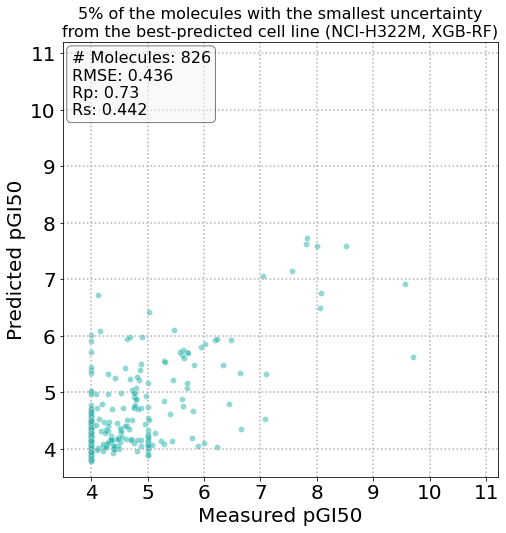

In [42]:
# CP VALID

print('MODEL: '+hx+'-'+gx)

title_plot = str(percentage_mols) +"% of the molecules with the smallest uncertainty\nfrom the best-predicted cell line "
name_plot = hx+'_'+gx+'BEST_CP_hx' # name to save the plot

plot_predicted_vs_observed_pGI50value(df_best_cl=list_one_cell_b[1], true_val=true_val, pred_val=pred_val,
                                      hx=hx+'-'+gx, type_mol='CP-valid molecules \n', 
                                      color='lightseagreen',
                                      metrics_res=metrics_res_b[0], title_plot=title_plot,
                                      cell=cell_b, name_plot=name_plot, 
                                      highest_p=6, type_val='', save_fig=False)


MODEL: XGB-RF


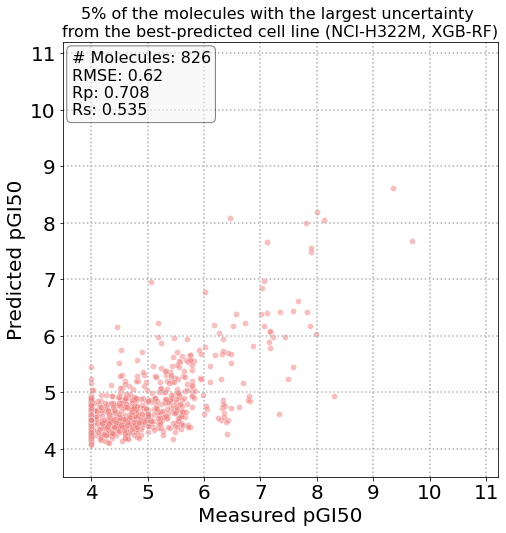

In [43]:
# CP invalid
print('MODEL: '+hx+'-'+gx)

title_plot_2 = str(percentage_mols) +"% of the molecules with the largest uncertainty \nfrom the best-predicted cell line "

plot_predicted_vs_observed_pGI50value(df_best_cl=list_one_cell_b[2], true_val=true_val, pred_val=pred_val,
                                      hx=hx+'-'+gx, type_mol='CP-invalid molecules \n',
                                      color='lightcoral',
                                      metrics_res=metrics_res_b[1], title_plot=title_plot_2,
                                      cell=cell_b, name_plot=name_plot, 
                                      highest_p=6, type_val='', save_fig=False)